# CPSC 330 - Applied Machine Learning 

## Homework 6: Clustering

**Associated lectures:** [Lectures 14 and 15](https://github.com/UBC-CS/cpsc330-2023W2/tree/main/lectures).
- We will use the concept of embeddings from [Lectures 16](https://github.com/UBC-CS/cpsc330-2023W2/tree/main/lectures). You can use it as a tool and do not need Lecture 16 to do the assignment, but feel free to take a look to get a better understanding!

**Due date: [Mar 25, 11:59pm](https://github.com/UBC-CS/cpsc330-2023W2?tab=readme-ov-file#deliverable-due-dates-tentative).**

## Imports <a name="im"></a>

In [123]:
import os
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN, KMeans
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline
pd.set_option("display.max_colwidth", 0)

<br><br><br><br>

## Submission instructions <a name="si"></a>
<hr>

_points: 2_

You will receive marks for correctly submitting this assignment. To submit this assignment, follow the instructions below:

- **You may work on this assignment in a group (group size $\leq$ 4) and submit your assignment as a group.** 
- Below are some instructions on working as a group.  
    - The maximum group size is 4. 
    - You can choose your own group members. 
    - Use group work as an opportunity to collaborate and learn new things from each other. 
    - Be respectful to each other and make sure you understand all the concepts in the assignment well. 
    - It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. [Here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members) are some instructions on adding group members in Gradescope.  
- Be sure to follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2023W2/blob/main/docs/homework_instructions.md).
- Upload the .ipynb file to PrairieLearn.

In [124]:
import numpy as np

np.random.randint(100, 10_000)

789

<br><br><br><br>

## Exercise 1: Document clustering warm-up
<hr>

In this homework, we will explore a popular application of clustering called [**document clustering**](https://en.wikipedia.org/wiki/Document_clustering). A large amount of unlabeled text data is available out there (e.g., news, recipes, online Q&A, tweets), and clustering is a commonly used technique to organize this data in a meaningful way. 

As a warm up, in this exercise, you will cluster sentences from a toy corpus. Later in the homework, you will work with a real corpus. 

The code below extracts introductory sentences of Wikipedia articles on a set of queries. To run the code successfully, you will need the `wikipedia` package installed in the course environment. 

```
conda activate cpsc330
conda install -c conda-forge wikipedia
```


**Your tasks:**

Run the code below which 
- extracts content of Wikipedia articles on a set of queries
- tokenizes the text (i.e., separates sentences) and 
- stores the 2nd sentence in each article as a document representing that article

> Feel free to experiment with Wikipedia queries of your choice. But stick to the provided list for the final submission so that it's easier for the TAs to grade your submission.

> For tokenization we are using the `nltk` package. If you do not have this package in the course environment, you will have to install it.

```
conda activate cpsc330
conda install -c anaconda nltk
```

Even if you have the package installed via the course `conda` environment, you might have to download `nltk` pre-trained models, which can be done with the code below.

In [125]:
import nltk

nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\priva\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [126]:
import wikipedia
from nltk.tokenize import sent_tokenize, word_tokenize

queries = [
    "hummus food",
    "bread food",
    "artificial intelligence",
    "unsupervised learning",
    "football sport",
    "ice hockey",
]

wiki_dict = {"wiki query": [], "text": [], "n_words": []}
for i in range(len(queries)):
    text = sent_tokenize(wikipedia.page(queries[i]).content)[1]
    wiki_dict["text"].append(text)
    wiki_dict["n_words"].append(len(word_tokenize(text)))
    wiki_dict["wiki query"].append(queries[i])

wiki_df = pd.DataFrame(wiki_dict)
wiki_df

,wiki query,text,n_words
0,hummus food,"The standard garnish in the Middle East includes olive oil, a few whole chickpeas, parsley, and paprika.The earliest mention of Hummus comes from Syria, in a 13th-century cookbook attributed to the Aleppine historian Ibn al-Adim.Popular in Middle Eastern cuisine, it is usually eaten as a dip, with pita bread.",56
1,bread food,"Throughout recorded history and around the world, it has been an important part of many cultures' diet.",20
2,artificial intelligence,"As a field of research in computer science focusing on the automation of intelligent behavior through machine learning, it develops and studies methods and software which enable machines to perceive their environment and take actions that maximize their chances of achieving defined goals, with the aim of performing tasks typically associated with human intelligence.",57
3,unsupervised learning,"The training data is processed, building a function that maps new data on expected output values.",18
4,football sport,"Sports can, through casual or organized participation, improve participants' physical health.",15
5,ice hockey,It belongs to a family of sports called hockey.,10


Our toy corpus has six toy documents (`text` column in the dataframe) extracted from Wikipedia queries. 

<br><br>

<!-- BEGIN QUESTION -->

### 1.1 How many clusters? 

_Points:_ 1

**Your tasks:**

1. If you are asked to cluster the documents from this toy corpus manually, how many clusters would you identify and how would you label each cluster?   

<div class="alert alert-warning">

Solution_1.1
    
</div>

3 Clusters:
1. Food
2. Machine Learning
3. Sports

<!-- END QUESTION -->

<br><br>

### 1.2 `KMeans` with bag-of-words representation 

_Points:_ 3

Before we pass text to machine learning models, we need to encode it to a numeric representation. We will try two representations: bag-of-words representation and sentence embedding representation. First, let's try our good old friend, bag-of-words.

**Your tasks:**

1. Create bag-of-words representation using [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) with `stop_words='english'` for the `text` column in `wiki_df` above. Store the representation in `transformed`.
2. Cluster the documents with this representation and [`KMeans` clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) with the following arguments: 
    - `random_state=42` (for reproducibility)
    - `n_clusters`=the number of clusters you identified in 1.1
3. Store the labels as a list in `kmeans_labels`

<div class="alert alert-warning">

Solution_1.2
    
</div>

In [127]:
countvec = CountVectorizer(stop_words='english')  # A variable for `CountVectorizer` object
transformed = countvec.fit_transform(wiki_df['text'])  # A variable for the BOW representation of words

In [128]:
kmeans_wiki = KMeans(n_clusters=3, random_state=42)  # KMeans object
kmeans_wiki.fit(transformed)
kmeans_labels = kmeans_wiki.labels_

kmeans_labels

array([2, 1, 0, 1, 1, 1])

<br><br>

### 1.3 Sentence embedding representation

_Points:_ 3

As we have seen before, bag-of-words representation is limited in that it does not take into account word ordering and context. There are other richer and more expressive representations of text, and we are going to use one such representation in this homework. We will call it **sentence embedding representation**. We'll use [sentence transformer](https://www.sbert.net/index.html) to extract these representations. At this point it's enough to know that this is an alternative representation of text which usually works better than simple bag-of-words representation. We will talk a bit more about embedding representations in the coming weeks. To use sentence transformer, you need to install `sentence-transformers` in the course conda environment to run the code below. 

```conda install -c conda-forge sentence-transformers```


**Your tasks:**

1. Run the code below to create sentence embedding representation of documents in our toy corpus. 
2. Cluster the documents with this representation (`emb_sents`) and `KMeans` with the following arguments: 
    - `random_state=42` (for reproducibility)
    - `n_clusters`=the number of clusters you identified in 1.1
3. Store the labels as a list in `kmeans_emb_labels`

In [129]:
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer("paraphrase-distilroberta-base-v1")

In [130]:
emb_sents = embedder.encode(wiki_df["text"])
emb_sent_df = pd.DataFrame(emb_sents, index=wiki_df.index)
emb_sent_df

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.186445,0.053468,-0.085373,0.142412,0.292351,0.111269,-0.026790,-0.284755,-0.052542,0.224934,...,0.239208,-0.011232,0.287064,0.084698,-0.050105,-0.100315,0.560232,0.243171,0.077927,-0.057998
1,-0.022417,0.217159,0.022694,0.003616,0.240856,0.358046,-0.053310,-0.328076,0.190012,0.244470,...,0.265413,-0.415595,0.003036,0.052484,0.345947,0.110091,0.405441,0.197792,-0.058253,0.212376
2,0.126692,0.186392,0.150296,0.382365,0.450249,-0.161789,0.084148,0.153292,0.255594,-0.223556,...,0.329319,-0.092291,-0.119608,0.053409,-0.128812,-0.054778,0.680740,-0.087321,0.033664,0.037519
3,0.258627,-0.285747,-0.248419,0.297078,0.214667,0.037092,-0.100457,0.057128,0.279170,0.049970,...,0.493944,-0.090611,0.320196,0.152408,-0.233400,0.105795,0.443150,-0.616379,0.254021,0.164758
4,0.401523,0.294518,0.169535,0.092036,0.159018,0.504919,0.392200,-0.074318,0.314625,0.033591,...,0.362093,-0.135943,0.133037,0.353604,-0.222303,0.077625,-0.082623,0.261560,0.272954,0.113219
5,0.108901,0.087363,0.119847,-0.050133,0.240210,-0.082101,0.190988,0.436203,-0.085558,-0.012788,...,0.145415,0.160033,0.071930,0.147640,0.043789,0.253031,-0.009358,0.415206,0.142142,0.130365


<div class="alert alert-warning">

Solution_1.3
    
</div>

In [131]:
kmeans_emb = KMeans(n_clusters=3, random_state=42)  # KMeans object
kmeans_emb.fit(emb_sent_df)
kmeans_emb_labels = kmeans_emb.labels_

kmeans_emb_labels

array([2, 2, 0, 0, 1, 1])

<br><br>

<!-- BEGIN QUESTION -->

### 1.4 DBSCAN with cosine distance  

_Points:_ 4

Let's try [`DBSCAN`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) on our toy dataset. K-Means is kind of bound to the Euclidean distance because it is based on the notion of means. With `DBSCAN` we can try different distance metrics. In the context of text, [cosine similarities](https://scikit-learn.org/stable/modules/metrics.html#cosine-similarity) or cosine distances tend to work better. Given vectors $u$ and $v$, the **cosine distance** between the vectors is defined as: 

$$distance_{cosine}(u,v) = 1 - (\frac{u \cdot v}{\left\lVert u\right\rVert_2 \left\lVert v\right\rVert_2})$$


**Your tasks:**

1. Cluster documents in our toy corpus encoded with sentence embedding representation (`emb_sents`) and [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html?highlight=dbscan#sklearn.cluster.DBSCAN) with `metric='cosine'`. 

> *Note: You will have to set appropriate values for the hyperparameters `eps` and `min_samples` to get meaningful clusters, as default values for these hyperparameters are unlikely to work on this toy dataset.*

<div class="alert alert-warning">

Solution_1.4
    
</div>

In [132]:
dbscan = DBSCAN(eps=0.75, min_samples=2, metric='cosine')
dbscan.fit(emb_sent_df)

dbscan.labels_

array([ 0,  0,  1,  1, -1, -1], dtype=int64)

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.5 Discussion

_Points:_ 4

**Your tasks:**

1. Reflect and comment on the clusters identified by each of the methods you explored in 1.2, 1.3, and 1.4. Are these methods doing a reasonable job in clustering the sentences in our toy corpus? Do the clustering results change with the representation you use?  

<div class="alert alert-warning">

Solution_1.5
    
</div>

The result from 1.2 is the worst, as it doesn't reflect what i see
result from 1.3 is amazing, as it accuately represents what i see, this has to do with encodeing the corpus with SentenceTransformer
result from 1.4 is better than 1.2 but not as good as 1.3, it failed to label the last two (marked as outliers)

<!-- END QUESTION -->

<br><br>

<br><br>

<!-- BEGIN QUESTION -->

### 1.6 Visualizing clusters

_Points:_ 3

One thing we can do with unlabeled data is visualizing it. That said, our data is high dimensional and high-dimensional data is hard to visualize. For example, in sentence embedding representation, each example is represented with 768 dimensions. One way to visualize high-dimensional data is by applying dimensionality reduction to get the most important (2 or 3) components of the dataset and visualizing this low-dimensional data. 

Given data as a `numpy` array and corresponding cluster assignments, the `plot_umap_clusters` function below transforms the data by applying dimensionality reduction technique called [UMAP](https://umap-learn.readthedocs.io/en/latest/) to it and plots the transformed data with different colours for different clusters. 

> *Note: At this point we are using this function only for visualization and you are not expected to understand the UMAP part.* 

You'll have to install the `umap-learn` package in the course conda environment either with `conda` or `pip`, as described in the [documentation](https://umap-learn.readthedocs.io/en/latest/index.html). 

```
> conda activate cpsc330
> conda install -c conda-forge umap-learn
```

or 

```
> conda activate cpsc330
> pip install umap-learn
```

**Your tasks:**

1. Visualize the clusters created by the three methods above using `plot_umap_clusters` function below:
    - KMeans with bag-of-words representation 
    - KMeans with sentence embedding representation
    - DBSCAN with sentence embedding representation  

In [133]:
# import umap
import umap.umap_ as umap

In [134]:
def plot_umap_clusters(
        data,
        cluster_labels,
        raw_sents=wiki_df["text"],
        show_labels=False,
        size=50,
        n_neighbors=15,
        title="UMAP visualization",
        ignore_noise=False,
):
    """
    Carry out dimensionality reduction using UMAP and plot 2-dimensional clusters.

    Parameters
    -----------
    data : numpy array
        data as a numpy array
    cluster_labels : list
        cluster labels for each row in the dataset
    raw_sents : list
        the original raw sentences for labeling datapoints
    show_labels : boolean
        whether you want to show labels for points or not (default: False)
    size : int
        size of points in the scatterplot
    n_neighbors : int
        n_neighbors hyperparameter of UMAP. See the documentation.
    title : str
        title for the visualization plot

    Returns
    -----------
    None. Shows the clusters.
    """

    reducer = umap.UMAP(n_neighbors=n_neighbors, random_state=42)
    Z = reducer.fit_transform(data)  # reduce dimensionality
    umap_df = pd.DataFrame(data=Z, columns=["dim1", "dim2"])
    umap_df["cluster"] = cluster_labels

    if ignore_noise:
        umap_df = umap_df[umap_df["cluster"] != -1]

    labels = np.unique(umap_df["cluster"])

    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_title(title)

    scatter = ax.scatter(
        umap_df["dim1"],
        umap_df["dim2"],
        c=umap_df["cluster"],
        cmap="tab20b",
        s=size,
        edgecolors="k",
        linewidths=0.1,
    )

    legend = ax.legend(*scatter.legend_elements(), loc="best", title="Clusters")
    ax.add_artist(legend)

    if show_labels:
        x = umap_df["dim1"].tolist()
        y = umap_df["dim2"].tolist()
        for i, txt in enumerate(raw_sents):
            ax.annotate(" ".join(txt.split()[:10]), (x[i], y[i]))
    plt.show()

<div class="alert alert-warning">

Solution_1.4
    
</div>

C:\Users\priva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\priva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


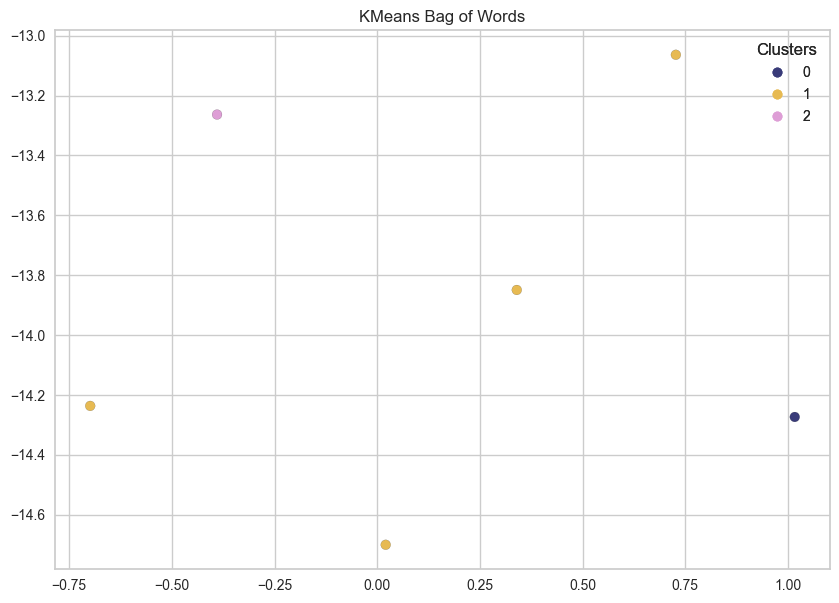

C:\Users\priva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\priva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


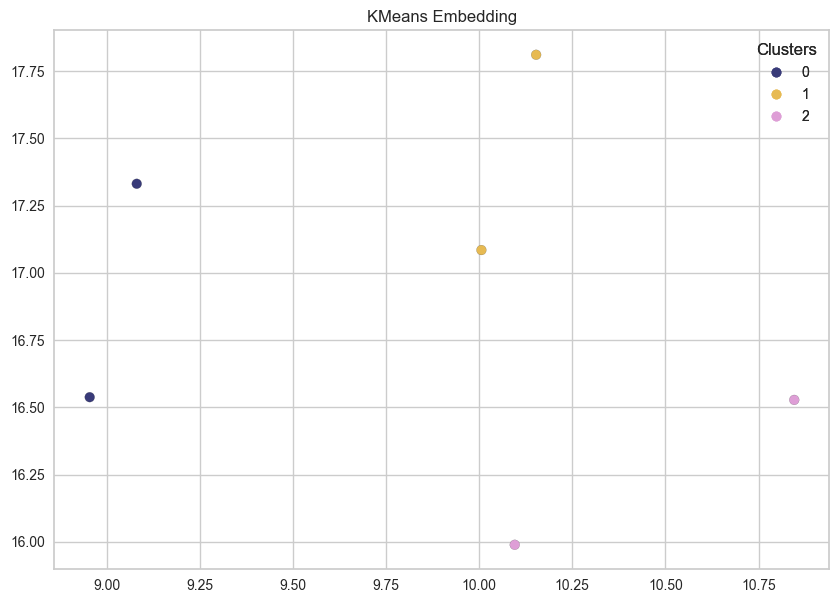

C:\Users\priva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\priva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


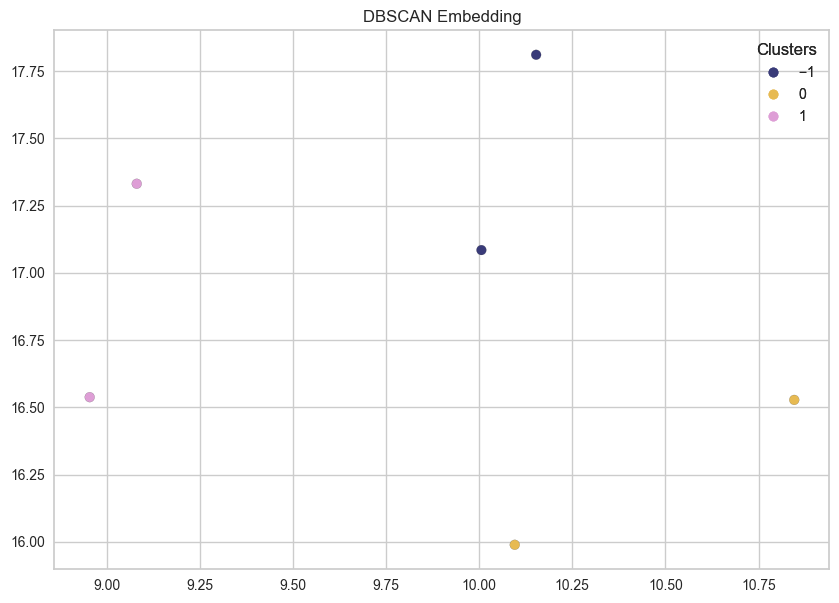

In [135]:
# Kmeans Bag of Words
plot_umap_clusters(transformed, kmeans_labels, title="KMeans Bag of Words")

# Kmeans Embedding
plot_umap_clusters(emb_sent_df, kmeans_emb_labels, title="KMeans Embedding")

# DBSCAN Embedding
plot_umap_clusters(emb_sent_df, dbscan.labels_, title="DBSCAN Embedding")

<!-- END QUESTION -->

<br><br><br><br>

## Exercise 2: [Food.com](https://www.food.com/) recipes 
<hr>

Now that we have applied document clustering on a toy dataset, let's cluster sentences from a real corpus. In this lab we will work with a sample of [Kaggle's Food.com recipes corpus]( https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions). This corpus contains 180K+ recipes and 700K+ recipe reviews. In this homework, we'll only focus on recipes and **not** on recipe reviews. The recipes are present in `RAW_recipes.csv`. Our goal is to find main categories or groupings of recipes based on their names. 

**Your tasks:**
- Download [`RAW_recipes.csv`](https://www.kaggle.com/shuyangli94/food-com-recipes-and-user-interactions?select=RAW_recipes.csv) and put it in the homework folder under the data folder. As usual, do not push the CSV in your repository. 
- Run the code below. The dataset is quite large, and in this assignment, for speed, you will work with a sample of the dataset. The function `get_recipes_sample` below carries out some preliminary preprocessing and returns a sample of the recipes with most frequent tags. 

> *Note: Depending upon the capacity of your computer, feel free to increase or decrease the size of this sample by changing the value for `n_tags`.* 

In [136]:
orig_recipes_df = pd.read_csv("data/RAW_recipes.csv")
orig_recipes_df.shape

(231637, 12)

In [137]:
# orig_recipes_df.head()

In [138]:
def get_recipes_sample(orig_recipes_df, n_tags=300, min_len=5):
    orig_recipes_df = orig_recipes_df.dropna()  # Remove rows with NaNs.
    orig_recipes_df = orig_recipes_df.drop_duplicates(
        "name"
    )  # Remove rows with duplicate names.
    # Remove rows where recipe names are too short (< 5 characters).
    orig_recipes_df = orig_recipes_df[orig_recipes_df["name"].apply(len) >= min_len]
    # Only consider the rows where tags are one of the most frequent n tags.
    first_n = orig_recipes_df["tags"].value_counts()[0:n_tags].index.tolist()
    recipes_df = orig_recipes_df[orig_recipes_df["tags"].isin(first_n)]
    return recipes_df

In [139]:
recipes_df = get_recipes_sample(orig_recipes_df)
recipes_df.shape

(9100, 12)

In [140]:
# recipes_df.head()

In [141]:
recipes_df["name"]

42        i yam what i yam  muffins    
101       to your health  muffins      
129       250 00 chocolate chip cookies
138       lplermagronen                
163       california roll   salad      
                   ...                 
231430    zucchini wheat germ cookies  
231514    zucchini blueberry bread     
231547    zucchini salsa burgers       
231596    zuppa toscana                
231629    zydeco salad                 
Name: name, Length: 9100, dtype: object

<br><br>

**In the rest of the homework, we will use `recipes_df` above, which is a subset of the original dataset.** 

<br><br>

### 2.1 Longest and shorted recipe names 

_Points:_ 2

**Your tasks:**

1. Print the shortest and longest recipe names (length in terms of number of characters) from `recipes_df`. If there is more than one recipe with the same shortest/longest length, store **one** in `shortest_recipe` and/or `longest_recipe` as a **string**.

<div class="alert alert-warning">

Solution_2.1
    
</div>

In [142]:
shortest_recipe = '                                                        '
longest_recipe = ''

for name in recipes_df["name"]:
    if len(name) > len(longest_recipe):
        longest_recipe = name

    if len(name) < len(shortest_recipe):
        shortest_recipe = name

print(shortest_recipe)
print(longest_recipe)


bread
baked tomatoes with a parmesan cheese crust and balsamic drizzle


<br><br>

<!-- BEGIN QUESTION -->

### 2.2 More EDA
rubric={points:2}

**Your tasks:**
1. Create a word cloud for the recipe names. You can use [the `wordcloud` package](https://github.com/amueller/word_cloud) for this, which you will have to install in the course environment. 

```
> conda activate cpsc330
> conda install -c conda-forge wordcloud
```

<div class="alert alert-warning">

Solution_2.2
    
</div>

_Points:_ 2

(-0.5, 399.5, 199.5, -0.5)

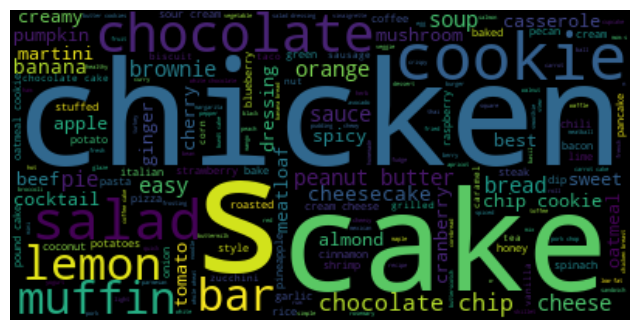

In [143]:
from wordcloud import WordCloud

wordcloud = WordCloud().generate(' '.join(recipes_df["name"]))

import matplotlib.pyplot as plt

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")


<!-- END QUESTION -->

<br><br>

### 2.3 Representing recipe names

_Points:_ 3

The next step is creating a representation of recipe names. 

**Your tasks:**

1. Similar to Exercise 1, create sentence embedding representation of recipe names (`name` column in `recipes_df`).  For the rest of the homework, we'll stick to the sentence embedding representation of recipe names.



> *If you create a dataframe with sentence embedding representation, set the index to `recipes_df.index` so that the indices match with the indices of the sample we are working with.*  
> *This might take a while to run.*

<div class="alert alert-warning">

Solution_2.3
    
</div>

In [144]:
embeddings = None

embedder = SentenceTransformer("paraphrase-distilroberta-base-v1")
emb_sents = embedder.encode(recipes_df["name"].tolist())
embeddings = pd.DataFrame(emb_sents, index=recipes_df.index)
embeddings

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
42,-0.333474,0.227865,-0.307339,0.410549,0.917103,-0.345506,0.305811,0.256676,-0.147712,0.040727,...,-0.053024,-0.209463,0.362418,-0.246085,0.208379,-0.024874,0.506561,0.197738,-0.386421,-0.002183
101,-0.024523,0.246223,-0.055709,0.358273,0.454786,-0.088055,0.260369,0.231947,0.093013,-0.007835,...,0.144860,-0.435459,0.208343,-0.002655,-0.081200,-0.130489,0.452378,0.186310,-0.278500,0.028580
129,-0.026562,0.194671,0.038102,-0.099181,0.653784,-0.230868,0.064517,0.001376,-0.061280,0.232094,...,0.169605,0.239355,0.392649,0.271398,-0.093971,0.060101,-0.281418,0.133210,-0.122344,-0.109863
138,-0.168002,-0.219218,0.330761,0.302197,-0.173169,0.204557,0.192390,0.140975,0.303174,0.038062,...,0.019095,-0.002447,0.437833,0.563785,0.033442,0.187657,0.529252,-0.233786,0.509931,0.410715
163,0.061076,-0.333798,0.242906,0.395977,-0.466469,0.496505,-0.136754,0.122097,0.114248,0.065317,...,0.044438,-0.213657,0.410353,-0.233599,-0.224422,0.094330,0.173351,0.105781,-0.114749,-0.150677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231430,-0.009714,0.200162,0.018329,0.237816,0.748988,0.121919,0.087918,0.216755,-0.291041,0.074165,...,-0.120458,0.162877,0.480065,0.235902,0.146278,0.252980,-0.063639,-0.066044,-0.133067,-0.034040
231514,-0.106532,-0.034574,0.160071,0.258504,0.882480,0.091899,0.008815,0.372013,-0.266542,0.085018,...,0.063240,-0.099133,0.332694,0.031869,0.582796,0.216874,0.241107,0.091759,-0.261551,-0.082310
231547,0.016149,-0.053035,-0.035097,-0.021835,0.735161,0.245519,-0.151837,0.003954,0.102567,0.001362,...,0.102296,0.023821,0.602685,-0.067071,0.177535,0.253982,0.242439,-0.436001,-0.053910,0.012423
231596,0.026659,0.202483,0.344633,-0.138708,0.514424,0.630947,-0.003165,-0.102896,-0.434900,-0.192056,...,-0.162458,0.130696,0.113645,0.186650,-0.155393,0.130507,1.146238,-0.240861,0.236831,0.177123


<br><br><br><br>

## Exercise 3: K-Means on Food.com recipe names

<!-- BEGIN QUESTION -->

### 3.1 Choosing K for K-Means

_Points:_ 6

For K-Means you need to specify the number of clusters in advance, which is often challenging to do on real datasets. As we saw in the lecture, there is no definitive method to select the number of clusters. That said, there are some approaches which may help us with this process. In this exercise, you'll explore three such approaches. 

**Your tasks:**

1. Consider a reasonable range of K (`n_clusters`) values and visualize the Elbow plot. 
2. Consider a reasonable range of K (`n_clusters`) and visualize the clusters created by K-Means by using `plot_umap_clusters` function from Exercise 1. 

> You may use the [`yellowbrick`](https://www.scikit-yb.org/en/latest/) package for visualizing the Elbow plot.   

```
pip install yellowbrick
```

> The range of K or `n_clusters` values does not have to be the same in the cases above. 

> Use the default value of `show_labels=False` when you call function `plot_umap_clusters`, as we do not want to display labels of thousands of data points.    

<div class="alert alert-warning">

Solution_3.1
    
</div>

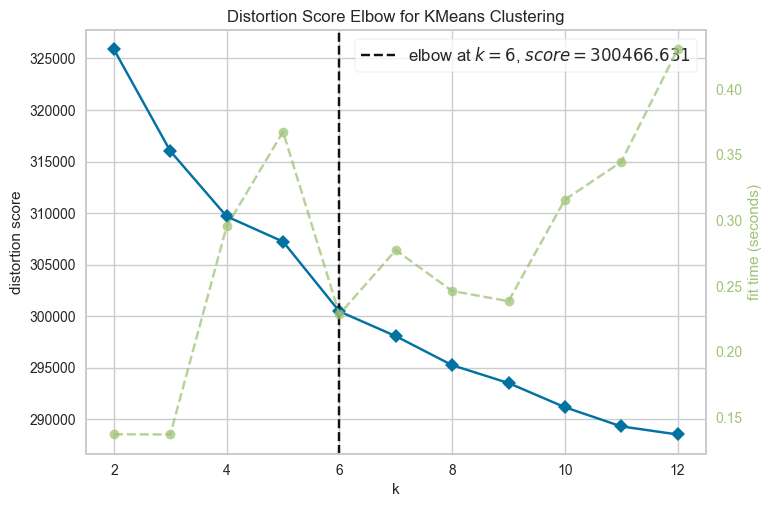

In [145]:
# from lec 14
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(n_init='auto')
visualizer = KElbowVisualizer(model, k=(2, 13))

visualizer.fit(embeddings)
visualizer.show();

C:\Users\priva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


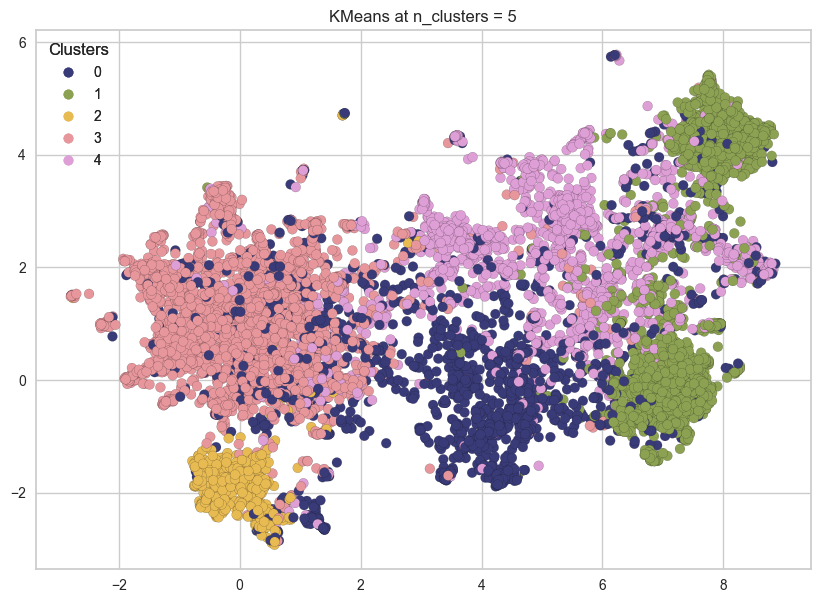

C:\Users\priva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


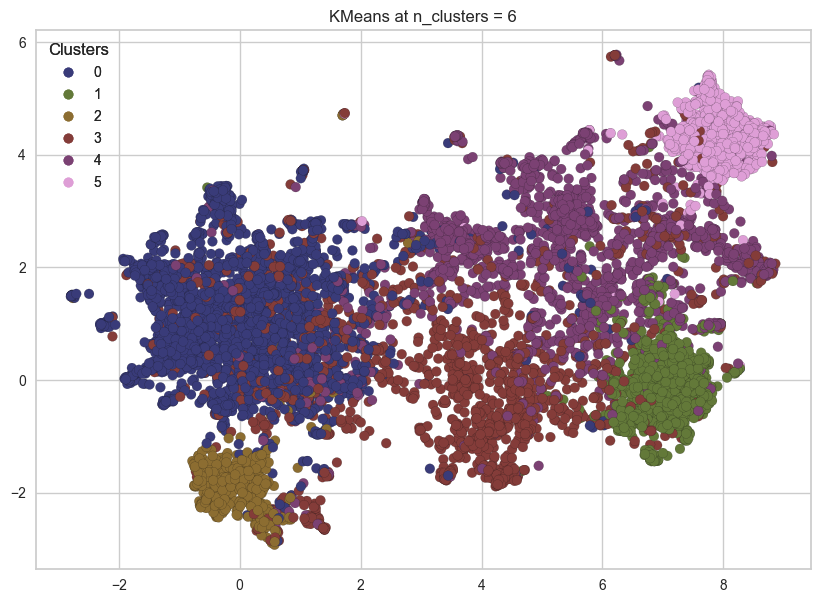

C:\Users\priva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


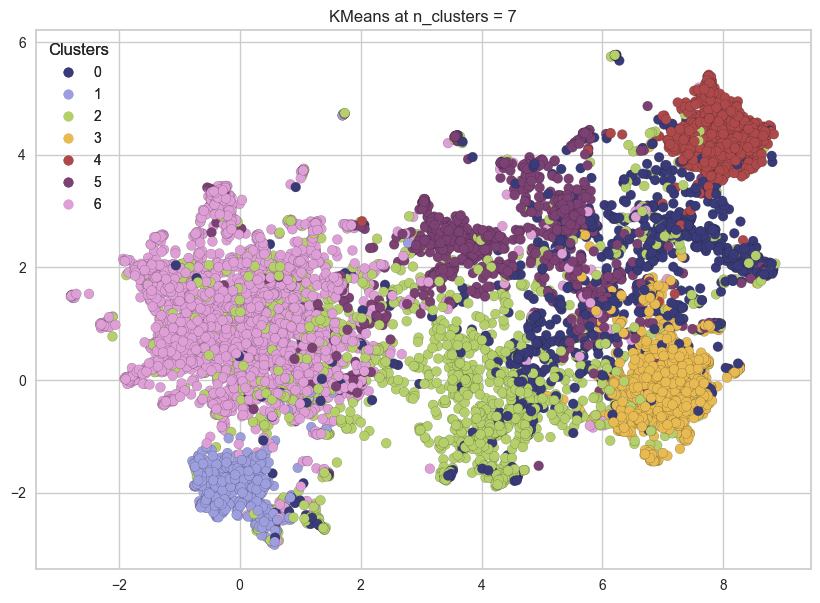

C:\Users\priva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


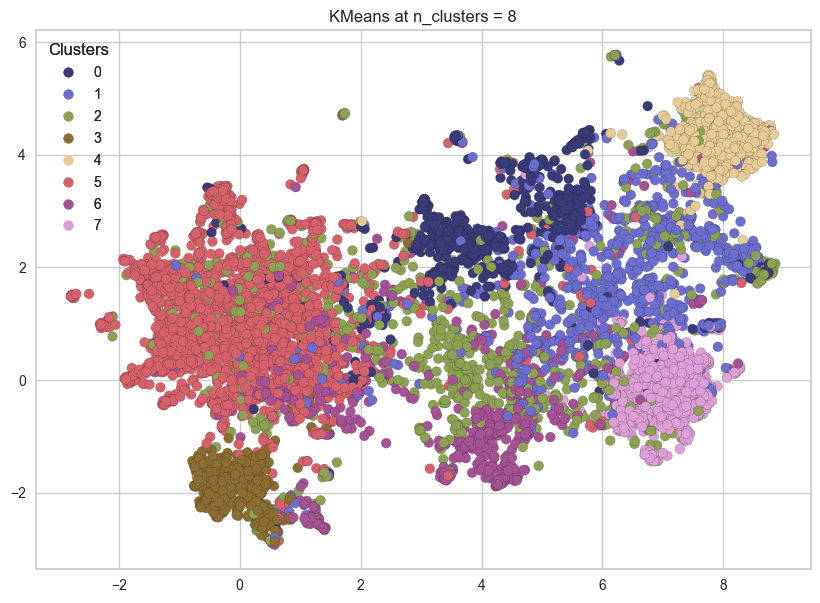

In [146]:
for n in range(5, 9):
    mod = KMeans(n_clusters=n)  # KMeans object
    mod.fit(embeddings)
    plot_umap_clusters(embeddings, mod.labels_, title="KMeans at n_clusters = " + str(n), show_labels=False)


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 3.2 Discussion 

_Points:_ 4

**Your tasks:** 
1. Comment on your results from 3.1. Are the plots above useful in narrowing down the range of values for `n_clusters`? Based on these visualizations, what value or a range of values seems reasonable for `n_clusters` in this problem? 

<div class="alert alert-warning">

Solution_3.2
    
</div>

The first plot helped me visualize how the inertia decreases as k increases, and it also provides an ideal value K. It gives me a broad idea of how much improvement each new cluster brings.
The second plot(s) explains what's happening under the hood, how each point is being assigned to each cluster.
To me, the value k = 7 seems the most reasonable, but there's not a clear and obvious best value, the inertia just keep going down at a relatively steady rate as k goes up (I've tested to k = 350, no clear cut off)

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 3.3 Sampling recipe names from clusters

_Points:_ 5

It's likely that with the methods in the previous exercises you did not get a satisfactory answer on how many clusters should be appropriate for this problem. One of the most important steps in clustering is manual interpretation of clusters. In this exercise, you will examine some samples from different clusters given by K-Means, which might give you a better understanding on the number of clusters and whether the clusters make sense or not.  

**Your tasks:**
1. Based on your answer in Exercise 3.1 and 3.2, pick one or two reasonable values for `n_clusters` and train `KMeans` with those values and `random_state=42`. 
2. Sample some examples (e.g., 10 to 15 recipe names) from each cluster and show the sampled recipes for each cluster. 

<div class="alert alert-warning">

Solution_3.3
    
</div>

In [147]:
n_clusters = 7
mod = KMeans(n_clusters=n_clusters, random_state=42)
mod.fit(embeddings)

KMeans(n_clusters=7, random_state=42)

In [148]:
labels = np.unique(np.array(mod.labels_))

res = {}
for label in labels:
    res[label] = []

names = np.array(recipes_df["name"])

for label in labels:
    for i in range(len(mod.labels_)):
        if label == mod.labels_[i]:
            res[label].append(names[i])

import random

for label in labels:
    n_shown = 0
    print()
    print("Cluster " + str(label) + " Samples: ")
    print()
    li = res[label].copy()
    random.shuffle(li)
    for i in range(len(li)):
        print(str(i + 1) + ". " + li[i])
        n_shown += 1
        if n_shown >= 11:
            break
        


Cluster 0 Samples: 

1. saltimbocca alla pollo
2. christiana campbell s tavern salmagundi
3. lemon balm vinaigrette
4. truly the best key lime pie martini
5. miss kitty s chili con carne
6. enchiladas de pollo   paula deen
7. vanilla vinaigrette
8. peachy martini
9. aquavit cranberry breeze
10. dreamsicle daiquiri
11. hawaiian pizza pineapples

Cluster 1 Samples: 

1. tomato bredie
2. spiked firefly palmer
3. afternoon pick me up
4. passion potion
5. traditional english tavern creamed corn
6. tequichi
7. zinger green tea drink
8. west s mango bramble
9. 8th birthday
10. green eyes
11. yogurt ranch dressing

Cluster 2 Samples: 

1. vermont maple spice cupcakes
2. vanessa s low glycemic load strawberry shortcake
3. savannah sweet potato bread
4. avocado quick bread
5. rustic french bread
6. moist cornbread with cheese
7. one of a kind bread pudding
8. nuts and berries
9. peanut butter banana chocolate train wreck
10. turkey cheeseburgers
11. capn crunch french toast

Cluster 3 Samples: 

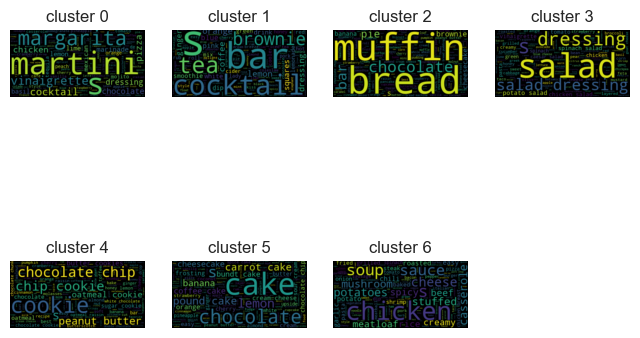

In [149]:
n = 1
for label in labels:
    wordcloud = WordCloud().generate(' '.join(res[label]))
    plt.subplot(2, 4, n)
    n += 1
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("cluster " + str(label))

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 3.4 Manual interpretation of clusters

_Points:_ 5

**Your tasks:**
1. Do you see a clear distinction between clusters? What topics/themes do to see in different clusters? 

<div class="alert alert-warning">

Solution_3.4
    
</div>

Yes I did see a clear distinction between clusters, here are the topics for each:
1. Appetizers
2. Snacks
3. Bakery
4. Salads
5. Cookies
6. Cakes
7. Main dishes

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 3.5 Dendrogram

_Points:_ 3

**Your tasks:**

1. Show a dendrogram with `p=10` and `truncate_mode=level` on sentence embeddings of recipes with average linkage and `metric="cosine"`.
2. Briefly comment on the results.

> *Note: Try orientation="left" of `dendrogram` for better readability of the dendrogram.*

<div class="alert alert-warning">

Solution_3.5
    
</div>

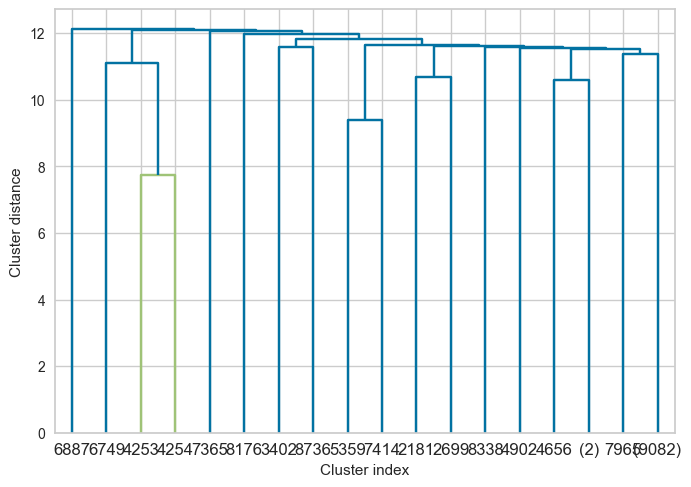

In [150]:
# from lec 15
from scipy.cluster.hierarchy import (
    average,
    complete,
    dendrogram,
    fcluster,
    single,
    ward,
)

linkage_array = average(embeddings)

from scipy.cluster.hierarchy import dendrogram

ax = plt.gca()
dendrogram(linkage_array, ax=ax, p=10, truncate_mode='level')
plt.xlabel("Cluster index")
plt.ylabel("Cluster distance");


Number of cluster = 10 should be the most ideal, as the dendrogram spent the longest time on cluster = 10

In [151]:
...

Ellipsis

In [152]:
...

Ellipsis

<!-- END QUESTION -->

<br><br><br><br>

**PLEASE READ BEFORE YOU SUBMIT:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using [PrairieLearn](https://ca.prairielearn.com/pl/course_instance/6697). Don't forget to rename your file `hw6_sol.ipynb`.

![](./img/eva-well-done.png)